## Import Libraries

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold

### 모델 학습 graph 

In [18]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

모델이 학습한 후의 그래프를 보여줍니다.  
정확도와 오차를 보기 쉽게 비교해줍니다.

### alphabet image

In [19]:
def digit_image(x):
    return np.where(x>=150, x, 0)

원본 이미지에서 숫자만 따로 추출하는 함수입니다.  
숫자 전부가 아닌 알파벳 마스크 때문에 가려진 부분은 추출되지 않을 것 입니다.

## Train

In [20]:
with open('./pickle/data.npy', 'rb') as f:
    X_trains= np.load(f)
    y_trains = np.load(f)
    TEST = np.load(f)

In [30]:
print(X_trains.shape)
print(y_trains.shape)
print(TEST.shape)

(2048, 28, 28, 3)
(2048, 10)
(20480, 28, 28, 3)


In [31]:
X_trains = X_trains.astype('float32') / 255.
TEST = TEST.astype('float32') / 255.

In [32]:
X_trains

array([[[[0.00392157, 0.        , 0.00392157],
         [0.00392157, 0.        , 0.00392157],
         [0.00392157, 0.        , 0.00392157],
         ...,
         [0.00784314, 0.        , 0.00784314],
         [0.        , 0.        , 0.        ],
         [0.01568628, 0.        , 0.01568628]],

        [[0.        , 0.        , 0.        ],
         [0.00392157, 0.        , 0.00392157],
         [0.01176471, 0.        , 0.01176471],
         ...,
         [0.01568628, 0.        , 0.01568628],
         [0.00392157, 0.        , 0.00392157],
         [0.01176471, 0.        , 0.01176471]],

        [[0.00784314, 0.        , 0.00784314],
         [0.        , 0.        , 0.        ],
         [0.01568628, 0.        , 0.01568628],
         ...,
         [0.01176471, 0.        , 0.01176471],
         [0.01176471, 0.        , 0.01176471],
         [0.01176471, 0.        , 0.01176471]],

        ...,

        [[0.00784314, 0.        , 0.00784314],
         [0.00392157, 0.        , 0.00392157]

In [33]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SeparableConv2D, Input, Conv2D, Add, BatchNormalization, concatenate, AveragePooling2D, add, MaxPooling2D 
from tensorflow.keras.layers import Conv2DTranspose, Activation, Dropout,UpSampling2D ,ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [34]:
reduction_ratio=16

### RexNet

In [35]:
def rexnet_model(shape):
    inputs = Input(shape=(28,28,3))

    conv1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), kernel_initializer='he_normal', activation='elu', padding='same',
                              kernel_constraint=tf.keras.constraints.max_norm(3.))(inputs) #28x28x128


    ## Residual Unit1
    batch1_1 = tf.keras.layers.BatchNormalization()(conv1)
    elu1_1 = tf.keras.layers.ELU()(batch1_1)
    res1_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_1) 
    batch1_2 = tf.keras.layers.BatchNormalization()(res1_1)
    elu1_2 = tf.keras.layers.ELU()(batch1_2)
    res1_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_2) 
    batch1_3 = tf.keras.layers.BatchNormalization()(res1_2)
    elu1_3 = tf.keras.layers.ELU()(batch1_3)
    res1_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_3)                          

    # SEBlock1
    ch_input1 = 128
    ch_reduced1 = ch_input1//reduction_ratio
    avpool1 = tf.keras.layers.GlobalAveragePooling2D()(res1_3)
    sed1_1 = tf.keras.layers.Dense(ch_reduced1, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool1)
    sed1_2 = tf.keras.layers.Dense(ch_input1, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed1_1)
    reshape1 = tf.keras.layers.Reshape((1,1,ch_input1))(sed1_2)
    mul1 = tf.keras.layers.Multiply()([res1_3, reshape1])
    #

    skip1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(conv1)
    res1 = tf.keras.layers.Add()([mul1, skip1]) #28x28x128
    ##

    ## Residual Unit2
    batch2_1 = tf.keras.layers.BatchNormalization()(res1)
    elu2_1 = tf.keras.layers.ELU()(batch2_1)
    res2_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_1) 
    batch2_2 = tf.keras.layers.BatchNormalization()(res2_1)
    elu2_2 = tf.keras.layers.ELU()(batch2_2)
    res2_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_2) 
    batch2_3 = tf.keras.layers.BatchNormalization()(res2_2)
    elu2_3 = tf.keras.layers.ELU()(batch2_3)
    res2_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_3)                         


    # SEBlock2
    ch_input2 = 128
    ch_reduced2 = ch_input2//reduction_ratio
    avpool2 = tf.keras.layers.GlobalAveragePooling2D()(res2_3)
    sed2_1 = tf.keras.layers.Dense(ch_reduced2, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool2)
    sed2_2 = tf.keras.layers.Dense(ch_input2, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed2_1)
    reshape2 = tf.keras.layers.Reshape((1,1,ch_input2))(sed2_2)
    mul2 = tf.keras.layers.Multiply()([res2_3, reshape2])
    #
    skip2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(res1)
    res2 = tf.keras.layers.Add()([mul2, skip2])
    drop2 = tf.keras.layers.Dropout(0.3)(res2) # 28x28x128
    ##


    ## Residual Unit3
    batch3_1 = tf.keras.layers.BatchNormalization()(drop2)
    elu3_1 = tf.keras.layers.ELU()(batch3_1)
    res3_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_1) 
    batch3_2 = tf.keras.layers.BatchNormalization()(res3_1)
    elu3_2 = tf.keras.layers.ELU()(batch3_2)
    res3_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_2) 
    batch3_3 = tf.keras.layers.BatchNormalization()(res3_2)
    elu3_3 = tf.keras.layers.ELU()(batch3_3)
    res3_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_3)                           


    # SEBlock3
    ch_input3 = 128
    ch_reduced3 = ch_input3//reduction_ratio
    avpool3 = tf.keras.layers.GlobalAveragePooling2D()(res3_3)
    sed3_1 = tf.keras.layers.Dense(ch_reduced3, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool3)
    sed3_2 = tf.keras.layers.Dense(ch_input3, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed3_1)
    reshape3 = tf.keras.layers.Reshape((1,1,ch_input3))(sed3_2)
    mul3 = tf.keras.layers.Multiply()([res3_3, reshape3])
    #
    skip3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1),padding='same')(drop2)
    res3 = tf.keras.layers.Add()([mul3, skip3]) #28x28x128
    ##


    ## Residual Unit4
    batch4_1 = tf.keras.layers.BatchNormalization()(res3)
    elu4_1 = tf.keras.layers.ELU()(batch4_1)
    res4_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_1) 
    batch4_2 = tf.keras.layers.BatchNormalization()(res4_1)
    elu4_2 = tf.keras.layers.ELU()(batch4_2)
    res4_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_2) 
    batch4_3 = tf.keras.layers.BatchNormalization()(res4_2)
    elu4_3 = tf.keras.layers.ELU()(batch4_3)
    res4_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_3)                              


    # SEBlock4
    ch_input4 = 256
    ch_reduced4 = ch_input4//reduction_ratio
    avpool4 = tf.keras.layers.GlobalAveragePooling2D()(res4_3)
    sed4_1 = tf.keras.layers.Dense(ch_reduced4, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool4)
    sed4_2 = tf.keras.layers.Dense(ch_input4, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed4_1)
    reshape4 = tf.keras.layers.Reshape((1,1,ch_input4))(sed4_2)
    mul4 = tf.keras.layers.Multiply()([res4_3, reshape4])
    #
    skip4 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(res3)
    res4 = tf.keras.layers.Add()([mul4, skip4])
    pool4 = tf.keras.layers.MaxPool2D((2,2))(res4)
    drop4 = tf.keras.layers.Dropout(0.3)(pool4) # 14x14x256
    ##


    ## Residual Unit5
    batch5_1 = tf.keras.layers.BatchNormalization()(drop4)
    elu5_1 = tf.keras.layers.ELU()(batch5_1)
    res5_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_1) 
    batch5_2 = tf.keras.layers.BatchNormalization()(res5_1)
    elu5_2 = tf.keras.layers.ELU()(batch5_2)
    res5_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_2) 
    batch5_3 = tf.keras.layers.BatchNormalization()(res5_2)
    elu5_3 = tf.keras.layers.ELU()(batch5_3)
    res5_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_3)                                 


    # SEBlock5
    ch_input5 = 256
    ch_reduced5 = ch_input5//reduction_ratio
    avpool5 = tf.keras.layers.GlobalAveragePooling2D()(res5_3)
    sed5_1 = tf.keras.layers.Dense(ch_reduced5, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool5)
    sed5_2 = tf.keras.layers.Dense(ch_input5, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed5_1)
    reshape5 = tf.keras.layers.Reshape((1,1,ch_input5))(sed5_2)
    mul5 = tf.keras.layers.Multiply()([res5_3, reshape5])
    #
    skip5 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(drop4)
    res5 = tf.keras.layers.Add()([mul5, skip5])
    pool5 = tf.keras.layers.MaxPool2D((2,2))(res5) #7x7x256
    ##


    ## Residual Unit6
    batch6_1 = tf.keras.layers.BatchNormalization()(pool5)
    elu6_1 = tf.keras.layers.ELU()(batch6_1)
    res6_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_1) 
    batch6_2 = tf.keras.layers.BatchNormalization()(res6_1)
    elu6_2 = tf.keras.layers.ELU()(batch6_2)
    res6_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_2) 
    batch6_3 = tf.keras.layers.BatchNormalization()(res6_2)
    elu6_3 = tf.keras.layers.ELU()(batch6_3)
    res6_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_3)
    # SEBlock6
    ch_input6 = 256
    ch_reduced6 = ch_input6//reduction_ratio
    avpool6 = tf.keras.layers.GlobalAveragePooling2D()(res6_3)
    sed6_1 = tf.keras.layers.Dense(ch_reduced6, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool6)
    sed6_2 = tf.keras.layers.Dense(ch_input6, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed6_1)
    reshape6 = tf.keras.layers.Reshape((1,1,ch_input6))(sed6_2)
    mul6 = tf.keras.layers.Multiply()([res6_3, reshape6])
    #
    skip6 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(pool5)
    res6 = tf.keras.layers.Add()([mul6, skip6])
    drop6 = tf.keras.layers.Dropout(0.3)(res6) # 7x7x256
    ##

    ## Residual Unit7
    batch7_1 = tf.keras.layers.BatchNormalization()(drop6)
    elu7_1 = tf.keras.layers.ELU()(batch7_1)
    res7_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_1) 
    batch7_2 = tf.keras.layers.BatchNormalization()(res7_1)
    elu7_2 = tf.keras.layers.ELU()(batch7_2)
    res7_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_2) 
    batch7_3 = tf.keras.layers.BatchNormalization()(res7_2)
    elu7_3 = tf.keras.layers.ELU()(batch7_3)
    res7_3 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_3)
    skip7 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1),padding='same')(drop6)
    res7 = tf.keras.layers.Add()([res7_3, skip7])
    pool7 = tf.keras.layers.MaxPool2D((3,3))(res7) 
    
    flatten1 = tf.keras.layers.Flatten()(pool7)
    
    dense1 = tf.keras.layers.Dense(1024, activation='elu', kernel_initializer='he_normal', kernel_constraint=tf.keras.constraints.max_norm(3.))(flatten1)
    
    drop1 = tf.keras.layers.Dropout(0.5)(dense1)
    outputs = tf.keras.layers.Dense(10 ,activation='softmax')(drop1)
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [36]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest'
)
datagen.fit(X_trains)

In [37]:
# 많은 데이터 셋으로 학습시키기 위해 FOLD를 100으로 설정했습니다. Fold 1 중간에 Stop시켰기에 break 조건을 넣어놨습니다.
def get_stacking(in_model, train, train_y, n_fold = 10, SEED=2020):
    k_fold = KFold(n_splits=8, shuffle=True, random_state=SEED)
    
    epochs = 500
    model_number = 0
    history = []
    batch_size = 32
    val_predict = []

    train_fold_predict = np.zeros((train.shape[0], 1))
    test_predict = []
    arm_test_predict = np.array([0]*204800).reshape(20480, 10).astype('float64')
    
    for cnt, (train_idx, val_idx) in enumerate(k_fold.split(train, train_y)):
        print(f'*******************number_{cnt+1}_kfold_model*******************')
        x_train, y_train = train[train_idx], train_y[train_idx]
        x_val, y_val = train[val_idx], train_y[val_idx]
        
        model = in_model(train.shape[1:])
        model.compile(loss="categorical_crossentropy",
                      optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
                      metrics=["accuracy"])

        es = EarlyStopping(patience=15, verbose=1)
        mc = ModelCheckpoint(f'./model/model1_best_{model_number}.h5', save_best_only=True, verbose=1)
        rlp = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.8, min_lr=0.0001)
        
        history = model.fit(datagen.flow(x_train, y_train, shuffle=True, batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_val, y_val),
                                  verbose=1,
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  validation_steps=x_val.shape[0] // batch_size,
                                  callbacks=[es, mc, rlp]
                                  )
        
#         history = model.fit(x_train, y_train, epochs = 53, validation_data=(x_val, y_val), verbose=1, batch_size = batch_size, callbacks = [es, mc, rlp])
        
        plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])
        
        
        model.load_weights(f'./model/model1_best_{model_number}.h5')
        pred_train = model.predict(x_val)
        pred_test = model.predict(TEST)
        
        train_fold_predict[val_idx, :] = np.argmax(pred_train, 1).reshape((x_val.shape[0], 1))
        
        test_predict.append(pred_test)
    
    for pred_test in test_predict:
        arm_test_predict += pred_test
          
    test_fold_predict = np.argmax(arm_test_predict, axis=1).reshape((TEST.shape[0], 1))
    train_fold_predict = train_fold_predict.astype('int64')
    
    return train_fold_predict, test_fold_predict

## Predict

*******************number_1_kfold_model*******************
Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 5.3834 - accuracy: 0.1170
Epoch 00001: val_loss improved from inf to 2.45399, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 3s 50ms/step - loss: 5.3418 - accuracy: 0.1161 - val_loss: 2.4540 - val_accuracy: 0.1133 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 2.8965 - accuracy: 0.1193
Epoch 00002: val_loss did not improve from 2.45399
56/56 [==============================] - 2s 36ms/step - loss: 2.9064 - accuracy: 0.1194 - val_loss: 3.2403 - val_accuracy: 0.1133 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 2.7931 - accuracy: 0.1443
Epoch 00003: val_loss did not improve from 2.45399
56/56 [==============================] - 2s 35ms/step - loss: 2.7881 - accuracy: 0.1451 - val_loss: 3.6053 - val_accuracy: 0.1172 - lr: 0.0010
Epoch 4/500
55/56 [=============

Epoch 28/500
55/56 [============================>.] - ETA: 0s - loss: 1.7381 - accuracy: 0.4142
Epoch 00028: val_loss did not improve from 1.29654
56/56 [==============================] - 2s 40ms/step - loss: 1.7310 - accuracy: 0.4146 - val_loss: 1.4253 - val_accuracy: 0.5391 - lr: 0.0010
Epoch 29/500
55/56 [============================>.] - ETA: 0s - loss: 1.6146 - accuracy: 0.4517
Epoch 00029: val_loss improved from 1.29654 to 1.22416, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 43ms/step - loss: 1.6187 - accuracy: 0.4487 - val_loss: 1.2242 - val_accuracy: 0.5898 - lr: 0.0010
Epoch 30/500
55/56 [============================>.] - ETA: 0s - loss: 1.6684 - accuracy: 0.4352
Epoch 00030: val_loss did not improve from 1.22416
56/56 [==============================] - 2s 38ms/step - loss: 1.6702 - accuracy: 0.4342 - val_loss: 1.6246 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 31/500
55/56 [============================>.] - ETA: 0s - loss: 1.6445 - accur

Epoch 55/500
55/56 [============================>.] - ETA: 0s - loss: 1.0543 - accuracy: 0.6392
Epoch 00055: val_loss did not improve from 0.79673
56/56 [==============================] - 2s 38ms/step - loss: 1.0609 - accuracy: 0.6362 - val_loss: 0.8847 - val_accuracy: 0.7148 - lr: 5.1200e-04
Epoch 56/500
55/56 [============================>.] - ETA: 0s - loss: 1.0358 - accuracy: 0.6364
Epoch 00056: val_loss did not improve from 0.79673
56/56 [==============================] - 2s 38ms/step - loss: 1.0392 - accuracy: 0.6356 - val_loss: 1.1745 - val_accuracy: 0.6758 - lr: 5.1200e-04
Epoch 57/500
55/56 [============================>.] - ETA: 0s - loss: 1.0460 - accuracy: 0.6386
Epoch 00057: val_loss did not improve from 0.79673
56/56 [==============================] - 2s 38ms/step - loss: 1.0428 - accuracy: 0.6401 - val_loss: 0.9141 - val_accuracy: 0.7109 - lr: 5.1200e-04
Epoch 58/500
55/56 [============================>.] - ETA: 0s - loss: 1.0682 - accuracy: 0.6420
Epoch 00058: val_loss 

Epoch 83/500
55/56 [============================>.] - ETA: 0s - loss: 0.7658 - accuracy: 0.7352
Epoch 00083: val_loss did not improve from 0.65188
56/56 [==============================] - 2s 38ms/step - loss: 0.7677 - accuracy: 0.7355 - val_loss: 0.7697 - val_accuracy: 0.7930 - lr: 1.6777e-04
Epoch 84/500
55/56 [============================>.] - ETA: 0s - loss: 0.6992 - accuracy: 0.7523
Epoch 00084: val_loss did not improve from 0.65188
56/56 [==============================] - 2s 38ms/step - loss: 0.6993 - accuracy: 0.7533 - val_loss: 0.8716 - val_accuracy: 0.7734 - lr: 1.6777e-04
Epoch 85/500
55/56 [============================>.] - ETA: 0s - loss: 0.7157 - accuracy: 0.7523
Epoch 00085: val_loss did not improve from 0.65188
56/56 [==============================] - 2s 38ms/step - loss: 0.7119 - accuracy: 0.7539 - val_loss: 0.7759 - val_accuracy: 0.7812 - lr: 1.6777e-04
Epoch 86/500
55/56 [============================>.] - ETA: 0s - loss: 0.7203 - accuracy: 0.7477
Epoch 00086: val_loss 

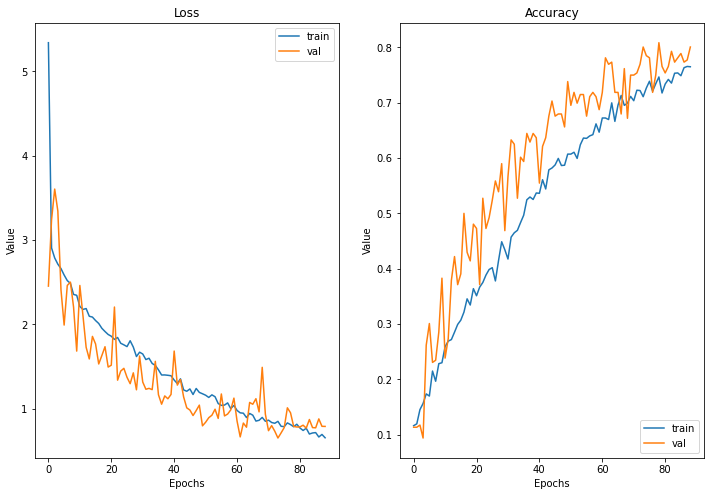

*******************number_2_kfold_model*******************
Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 4.8491 - accuracy: 0.1318
Epoch 00001: val_loss improved from inf to 3.14331, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 3s 50ms/step - loss: 4.8152 - accuracy: 0.1323 - val_loss: 3.1433 - val_accuracy: 0.0820 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 2.8854 - accuracy: 0.1369
Epoch 00002: val_loss did not improve from 3.14331
56/56 [==============================] - 2s 38ms/step - loss: 2.8773 - accuracy: 0.1378 - val_loss: 3.3144 - val_accuracy: 0.1172 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 2.8265 - accuracy: 0.1562
Epoch 00003: val_loss did not improve from 3.14331
56/56 [==============================] - 2s 38ms/step - loss: 2.8244 - accuracy: 0.1562 - val_loss: 3.2379 - val_accuracy: 0.1133 - lr: 0.0010
Epoch 4/500
55/56 [=============

55/56 [============================>.] - ETA: 0s - loss: 1.6749 - accuracy: 0.4267
Epoch 00027: val_loss improved from 1.16168 to 0.93951, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 42ms/step - loss: 1.6706 - accuracy: 0.4286 - val_loss: 0.9395 - val_accuracy: 0.7031 - lr: 6.4000e-04
Epoch 28/500
55/56 [============================>.] - ETA: 0s - loss: 1.6167 - accuracy: 0.4398
Epoch 00028: val_loss did not improve from 0.93951
56/56 [==============================] - 2s 38ms/step - loss: 1.6147 - accuracy: 0.4414 - val_loss: 0.9654 - val_accuracy: 0.6758 - lr: 6.4000e-04
Epoch 29/500
55/56 [============================>.] - ETA: 0s - loss: 1.6311 - accuracy: 0.4347
Epoch 00029: val_loss did not improve from 0.93951
56/56 [==============================] - 2s 38ms/step - loss: 1.6309 - accuracy: 0.4347 - val_loss: 1.2415 - val_accuracy: 0.5625 - lr: 6.4000e-04
Epoch 30/500
55/56 [============================>.] - ETA: 0s - loss: 1.5676 - accura

Epoch 54/500
55/56 [============================>.] - ETA: 0s - loss: 1.0734 - accuracy: 0.6335
Epoch 00054: val_loss did not improve from 0.57571
56/56 [==============================] - 2s 38ms/step - loss: 1.0703 - accuracy: 0.6345 - val_loss: 0.7049 - val_accuracy: 0.7461 - lr: 2.6214e-04
Epoch 55/500
55/56 [============================>.] - ETA: 0s - loss: 1.0426 - accuracy: 0.6432
Epoch 00055: val_loss improved from 0.57571 to 0.55075, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 42ms/step - loss: 1.0416 - accuracy: 0.6434 - val_loss: 0.5507 - val_accuracy: 0.8125 - lr: 2.6214e-04
Epoch 56/500
55/56 [============================>.] - ETA: 0s - loss: 1.0313 - accuracy: 0.6432
Epoch 00056: val_loss improved from 0.55075 to 0.51859, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 42ms/step - loss: 1.0286 - accuracy: 0.6445 - val_loss: 0.5186 - val_accuracy: 0.8086 - lr: 2.6214e-04
Epoch 57/500
55/56 [======

55/56 [============================>.] - ETA: 0s - loss: 0.8442 - accuracy: 0.7068
Epoch 00081: val_loss did not improve from 0.42237
56/56 [==============================] - 2s 38ms/step - loss: 0.8440 - accuracy: 0.7076 - val_loss: 0.4819 - val_accuracy: 0.8203 - lr: 1.0737e-04
Epoch 82/500
55/56 [============================>.] - ETA: 0s - loss: 0.8408 - accuracy: 0.7114
Epoch 00082: val_loss did not improve from 0.42237
56/56 [==============================] - 2s 38ms/step - loss: 0.8451 - accuracy: 0.7098 - val_loss: 0.4515 - val_accuracy: 0.8477 - lr: 1.0737e-04
Epoch 83/500
55/56 [============================>.] - ETA: 0s - loss: 0.8146 - accuracy: 0.7193
Epoch 00083: val_loss did not improve from 0.42237
56/56 [==============================] - 2s 38ms/step - loss: 0.8166 - accuracy: 0.7171 - val_loss: 0.5103 - val_accuracy: 0.8086 - lr: 1.0737e-04
Epoch 84/500
55/56 [============================>.] - ETA: 0s - loss: 0.8228 - accuracy: 0.7159
Epoch 00084: val_loss did not impro

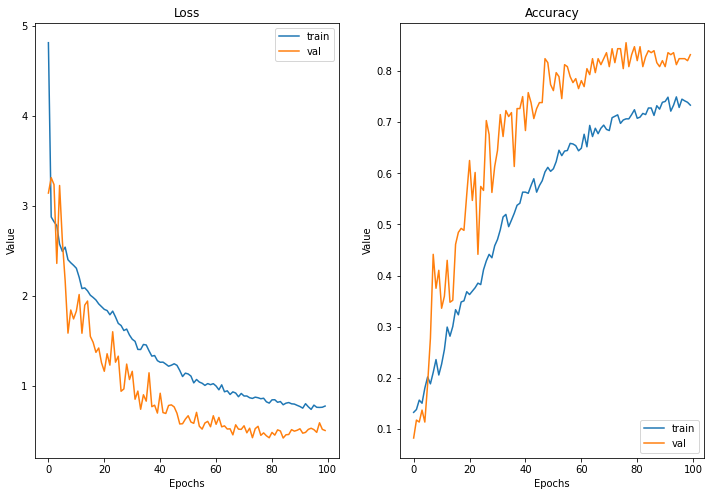

*******************number_3_kfold_model*******************
Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 4.8549 - accuracy: 0.1182
Epoch 00001: val_loss improved from inf to 2.48561, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 3s 49ms/step - loss: 4.8237 - accuracy: 0.1183 - val_loss: 2.4856 - val_accuracy: 0.1484 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 2.8674 - accuracy: 0.1290
Epoch 00002: val_loss did not improve from 2.48561
56/56 [==============================] - 2s 38ms/step - loss: 2.8643 - accuracy: 0.1289 - val_loss: 2.5647 - val_accuracy: 0.1523 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 2.8748 - accuracy: 0.1392
Epoch 00003: val_loss did not improve from 2.48561
56/56 [==============================] - 2s 38ms/step - loss: 2.8731 - accuracy: 0.1390 - val_loss: 3.4304 - val_accuracy: 0.1016 - lr: 0.0010
Epoch 4/500
55/56 [=============

Epoch 28/500
55/56 [============================>.] - ETA: 0s - loss: 1.6574 - accuracy: 0.4295
Epoch 00028: val_loss did not improve from 1.19448
56/56 [==============================] - 2s 38ms/step - loss: 1.6592 - accuracy: 0.4269 - val_loss: 1.2268 - val_accuracy: 0.6055 - lr: 6.4000e-04
Epoch 29/500
55/56 [============================>.] - ETA: 0s - loss: 1.7124 - accuracy: 0.4131
Epoch 00029: val_loss did not improve from 1.19448
56/56 [==============================] - 2s 38ms/step - loss: 1.7168 - accuracy: 0.4107 - val_loss: 1.1993 - val_accuracy: 0.5820 - lr: 6.4000e-04
Epoch 30/500
55/56 [============================>.] - ETA: 0s - loss: 1.6368 - accuracy: 0.4540
Epoch 00030: val_loss did not improve from 1.19448
56/56 [==============================] - 2s 38ms/step - loss: 1.6383 - accuracy: 0.4542 - val_loss: 1.1988 - val_accuracy: 0.6016 - lr: 6.4000e-04
Epoch 31/500
55/56 [============================>.] - ETA: 0s - loss: 1.5738 - accuracy: 0.4574
Epoch 00031: val_loss 

55/56 [============================>.] - ETA: 0s - loss: 1.1720 - accuracy: 0.6023
Epoch 00054: val_loss did not improve from 0.80356
56/56 [==============================] - 2s 38ms/step - loss: 1.1668 - accuracy: 0.6044 - val_loss: 0.8314 - val_accuracy: 0.7773 - lr: 5.1200e-04
Epoch 55/500
55/56 [============================>.] - ETA: 0s - loss: 1.1681 - accuracy: 0.5977
Epoch 00055: val_loss did not improve from 0.80356
56/56 [==============================] - 2s 38ms/step - loss: 1.1649 - accuracy: 0.5988 - val_loss: 0.8388 - val_accuracy: 0.7617 - lr: 5.1200e-04
Epoch 56/500
55/56 [============================>.] - ETA: 0s - loss: 1.1352 - accuracy: 0.6114
Epoch 00056: val_loss improved from 0.80356 to 0.73701, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 43ms/step - loss: 1.1350 - accuracy: 0.6122 - val_loss: 0.7370 - val_accuracy: 0.7656 - lr: 4.0960e-04
Epoch 57/500
55/56 [============================>.] - ETA: 0s - loss: 1.1018 - accura

55/56 [============================>.] - ETA: 0s - loss: 0.8511 - accuracy: 0.7216
Epoch 00081: val_loss did not improve from 0.58508
56/56 [==============================] - 2s 38ms/step - loss: 0.8518 - accuracy: 0.7221 - val_loss: 0.7220 - val_accuracy: 0.8125 - lr: 2.6214e-04
Epoch 82/500
55/56 [============================>.] - ETA: 0s - loss: 0.8153 - accuracy: 0.7159
Epoch 00082: val_loss did not improve from 0.58508
56/56 [==============================] - 2s 38ms/step - loss: 0.8108 - accuracy: 0.7171 - val_loss: 0.6773 - val_accuracy: 0.7930 - lr: 2.0972e-04
Epoch 83/500
55/56 [============================>.] - ETA: 0s - loss: 0.7890 - accuracy: 0.7324
Epoch 00083: val_loss improved from 0.58508 to 0.52958, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 43ms/step - loss: 0.7836 - accuracy: 0.7344 - val_loss: 0.5296 - val_accuracy: 0.8398 - lr: 2.0972e-04
Epoch 84/500
55/56 [============================>.] - ETA: 0s - loss: 0.7792 - accura

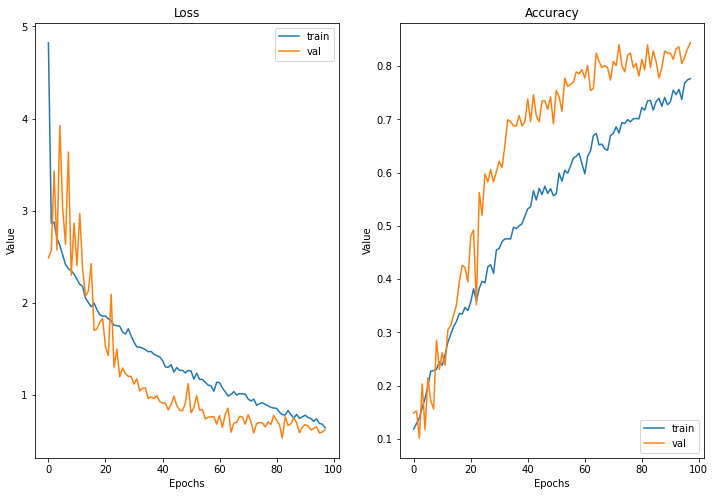

*******************number_4_kfold_model*******************
Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 4.6976 - accuracy: 0.1227
Epoch 00001: val_loss improved from inf to 2.49920, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 3s 48ms/step - loss: 4.6587 - accuracy: 0.1211 - val_loss: 2.4992 - val_accuracy: 0.1484 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 2.9183 - accuracy: 0.1278
Epoch 00002: val_loss did not improve from 2.49920
56/56 [==============================] - 2s 38ms/step - loss: 2.9191 - accuracy: 0.1283 - val_loss: 2.9275 - val_accuracy: 0.1680 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 2.7605 - accuracy: 0.1591
Epoch 00003: val_loss did not improve from 2.49920
56/56 [==============================] - 2s 38ms/step - loss: 2.7637 - accuracy: 0.1579 - val_loss: 2.5301 - val_accuracy: 0.1797 - lr: 0.0010
Epoch 4/500
55/56 [=============

56/56 [==============================] - 2s 39ms/step - loss: 1.8119 - accuracy: 0.3750 - val_loss: 1.2476 - val_accuracy: 0.6133 - lr: 0.0010
Epoch 28/500
55/56 [============================>.] - ETA: 0s - loss: 1.6973 - accuracy: 0.4153
Epoch 00028: val_loss did not improve from 1.24759
56/56 [==============================] - 2s 35ms/step - loss: 1.6939 - accuracy: 0.4185 - val_loss: 1.4284 - val_accuracy: 0.5234 - lr: 0.0010
Epoch 29/500
55/56 [============================>.] - ETA: 0s - loss: 1.7079 - accuracy: 0.4222
Epoch 00029: val_loss improved from 1.24759 to 1.22715, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 39ms/step - loss: 1.7112 - accuracy: 0.4196 - val_loss: 1.2271 - val_accuracy: 0.5391 - lr: 0.0010
Epoch 30/500
55/56 [============================>.] - ETA: 0s - loss: 1.7148 - accuracy: 0.4295
Epoch 00030: val_loss did not improve from 1.22715
56/56 [==============================] - 2s 35ms/step - loss: 1.7155 - accuracy: 0.4

55/56 [============================>.] - ETA: 0s - loss: 1.2588 - accuracy: 0.5813
Epoch 00054: val_loss did not improve from 0.58513
56/56 [==============================] - 2s 35ms/step - loss: 1.2554 - accuracy: 0.5820 - val_loss: 1.1013 - val_accuracy: 0.6914 - lr: 8.0000e-04
Epoch 55/500
55/56 [============================>.] - ETA: 0s - loss: 1.2064 - accuracy: 0.5972
Epoch 00055: val_loss improved from 0.58513 to 0.56513, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 39ms/step - loss: 1.2108 - accuracy: 0.5949 - val_loss: 0.5651 - val_accuracy: 0.7852 - lr: 6.4000e-04
Epoch 56/500
55/56 [============================>.] - ETA: 0s - loss: 1.1325 - accuracy: 0.6097
Epoch 00056: val_loss did not improve from 0.56513
56/56 [==============================] - 2s 35ms/step - loss: 1.1315 - accuracy: 0.6099 - val_loss: 0.7719 - val_accuracy: 0.7305 - lr: 6.4000e-04
Epoch 57/500
55/56 [============================>.] - ETA: 0s - loss: 1.1827 - accura

Epoch 82/500
55/56 [============================>.] - ETA: 0s - loss: 0.7932 - accuracy: 0.7284
Epoch 00082: val_loss did not improve from 0.46231
56/56 [==============================] - 2s 35ms/step - loss: 0.7888 - accuracy: 0.7294 - val_loss: 0.4684 - val_accuracy: 0.8750 - lr: 2.0972e-04
Epoch 83/500
55/56 [============================>.] - ETA: 0s - loss: 0.7277 - accuracy: 0.7477
Epoch 00083: val_loss did not improve from 0.46231
56/56 [==============================] - 2s 35ms/step - loss: 0.7223 - accuracy: 0.7494 - val_loss: 0.5650 - val_accuracy: 0.8359 - lr: 2.0972e-04
Epoch 84/500
55/56 [============================>.] - ETA: 0s - loss: 0.7544 - accuracy: 0.7273
Epoch 00084: val_loss did not improve from 0.46231
56/56 [==============================] - 2s 35ms/step - loss: 0.7538 - accuracy: 0.7266 - val_loss: 0.5211 - val_accuracy: 0.8242 - lr: 1.6777e-04
Epoch 85/500
55/56 [============================>.] - ETA: 0s - loss: 0.7180 - accuracy: 0.7528
Epoch 00085: val_loss 

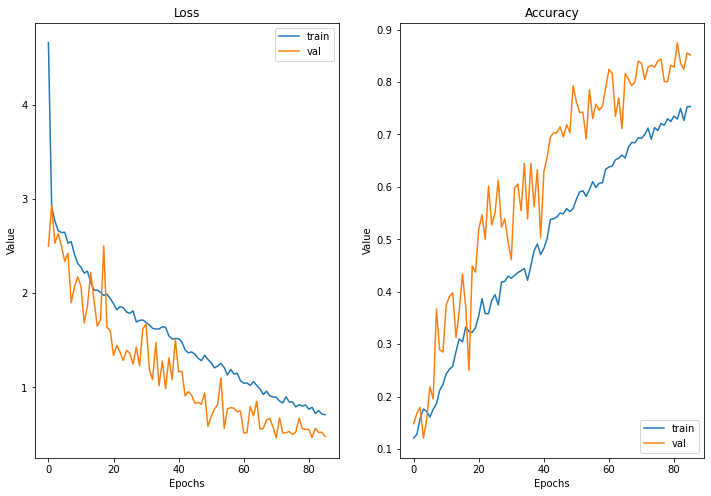

*******************number_5_kfold_model*******************
Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 5.1166 - accuracy: 0.1097
Epoch 00001: val_loss improved from inf to 2.88471, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 3s 46ms/step - loss: 5.0811 - accuracy: 0.1094 - val_loss: 2.8847 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 2.8942 - accuracy: 0.1330
Epoch 00002: val_loss did not improve from 2.88471
56/56 [==============================] - 2s 35ms/step - loss: 2.8867 - accuracy: 0.1345 - val_loss: 3.6826 - val_accuracy: 0.1016 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 2.8321 - accuracy: 0.1494
Epoch 00003: val_loss did not improve from 2.88471
56/56 [==============================] - 2s 35ms/step - loss: 2.8320 - accuracy: 0.1496 - val_loss: 4.5556 - val_accuracy: 0.1016 - lr: 0.0010
Epoch 4/500
55/56 [=============

55/56 [============================>.] - ETA: 0s - loss: 1.6569 - accuracy: 0.4284
Epoch 00027: val_loss improved from 1.20688 to 1.01728, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 39ms/step - loss: 1.6573 - accuracy: 0.4280 - val_loss: 1.0173 - val_accuracy: 0.6719 - lr: 8.0000e-04
Epoch 28/500
55/56 [============================>.] - ETA: 0s - loss: 1.5788 - accuracy: 0.4551
Epoch 00028: val_loss did not improve from 1.01728
56/56 [==============================] - 2s 35ms/step - loss: 1.5743 - accuracy: 0.4576 - val_loss: 1.0924 - val_accuracy: 0.6328 - lr: 8.0000e-04
Epoch 29/500
55/56 [============================>.] - ETA: 0s - loss: 1.6243 - accuracy: 0.4494
Epoch 00029: val_loss did not improve from 1.01728
56/56 [==============================] - 2s 35ms/step - loss: 1.6290 - accuracy: 0.4481 - val_loss: 1.2156 - val_accuracy: 0.6055 - lr: 8.0000e-04
Epoch 30/500
55/56 [============================>.] - ETA: 0s - loss: 1.5415 - accura

Epoch 54/500
55/56 [============================>.] - ETA: 0s - loss: 1.0839 - accuracy: 0.6352
Epoch 00054: val_loss improved from 0.62306 to 0.55873, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 39ms/step - loss: 1.0825 - accuracy: 0.6362 - val_loss: 0.5587 - val_accuracy: 0.8125 - lr: 5.1200e-04
Epoch 55/500
55/56 [============================>.] - ETA: 0s - loss: 1.0548 - accuracy: 0.6500
Epoch 00055: val_loss improved from 0.55873 to 0.55090, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 40ms/step - loss: 1.0519 - accuracy: 0.6507 - val_loss: 0.5509 - val_accuracy: 0.8047 - lr: 5.1200e-04
Epoch 56/500
55/56 [============================>.] - ETA: 0s - loss: 1.0601 - accuracy: 0.6324
Epoch 00056: val_loss did not improve from 0.55090
56/56 [==============================] - 2s 35ms/step - loss: 1.0651 - accuracy: 0.6306 - val_loss: 0.5674 - val_accuracy: 0.7773 - lr: 5.1200e-04
Epoch 57/500
55/56 [======

Epoch 81/500
55/56 [============================>.] - ETA: 0s - loss: 0.7470 - accuracy: 0.7455
Epoch 00081: val_loss did not improve from 0.39998
56/56 [==============================] - 2s 35ms/step - loss: 0.7473 - accuracy: 0.7461 - val_loss: 0.4661 - val_accuracy: 0.8398 - lr: 1.6777e-04
Epoch 82/500
55/56 [============================>.] - ETA: 0s - loss: 0.7375 - accuracy: 0.7568
Epoch 00082: val_loss did not improve from 0.39998
56/56 [==============================] - 2s 35ms/step - loss: 0.7377 - accuracy: 0.7556 - val_loss: 0.4412 - val_accuracy: 0.8750 - lr: 1.6777e-04
Epoch 83/500
55/56 [============================>.] - ETA: 0s - loss: 0.7371 - accuracy: 0.7534
Epoch 00083: val_loss improved from 0.39998 to 0.38658, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 39ms/step - loss: 0.7380 - accuracy: 0.7539 - val_loss: 0.3866 - val_accuracy: 0.8516 - lr: 1.6777e-04
Epoch 84/500
55/56 [============================>.] - ETA: 0s - loss: 0.

55/56 [============================>.] - ETA: 0s - loss: 0.6260 - accuracy: 0.7926
Epoch 00108: val_loss did not improve from 0.35044
56/56 [==============================] - 2s 35ms/step - loss: 0.6290 - accuracy: 0.7919 - val_loss: 0.3679 - val_accuracy: 0.8594 - lr: 1.0000e-04
Epoch 109/500
55/56 [============================>.] - ETA: 0s - loss: 0.6398 - accuracy: 0.7784
Epoch 00109: val_loss did not improve from 0.35044
56/56 [==============================] - 2s 35ms/step - loss: 0.6327 - accuracy: 0.7818 - val_loss: 0.3645 - val_accuracy: 0.8906 - lr: 1.0000e-04
Epoch 110/500
55/56 [============================>.] - ETA: 0s - loss: 0.6302 - accuracy: 0.7915
Epoch 00110: val_loss did not improve from 0.35044
56/56 [==============================] - 2s 35ms/step - loss: 0.6336 - accuracy: 0.7902 - val_loss: 0.3689 - val_accuracy: 0.8867 - lr: 1.0000e-04
Epoch 111/500
55/56 [============================>.] - ETA: 0s - loss: 0.5959 - accuracy: 0.7955
Epoch 00111: val_loss did not im

Epoch 00135: early stopping


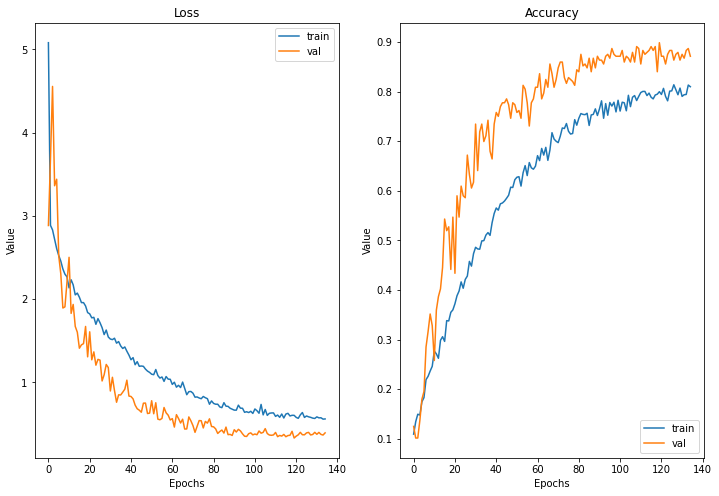

*******************number_6_kfold_model*******************
Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 4.8997 - accuracy: 0.1119
Epoch 00001: val_loss improved from inf to 2.27417, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 3s 46ms/step - loss: 4.8667 - accuracy: 0.1105 - val_loss: 2.2742 - val_accuracy: 0.1484 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 3.0013 - accuracy: 0.1148
Epoch 00002: val_loss did not improve from 2.27417
56/56 [==============================] - 2s 35ms/step - loss: 2.9937 - accuracy: 0.1172 - val_loss: 2.8742 - val_accuracy: 0.1836 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 2.8243 - accuracy: 0.1392
Epoch 00003: val_loss did not improve from 2.27417
56/56 [==============================] - 2s 35ms/step - loss: 2.8247 - accuracy: 0.1390 - val_loss: 2.9093 - val_accuracy: 0.2070 - lr: 0.0010
Epoch 4/500
55/56 [=============

55/56 [============================>.] - ETA: 0s - loss: 1.6495 - accuracy: 0.4290
Epoch 00027: val_loss did not improve from 1.00827
56/56 [==============================] - 2s 35ms/step - loss: 1.6493 - accuracy: 0.4291 - val_loss: 1.2167 - val_accuracy: 0.6016 - lr: 6.4000e-04
Epoch 28/500
55/56 [============================>.] - ETA: 0s - loss: 1.7028 - accuracy: 0.4250
Epoch 00028: val_loss did not improve from 1.00827
56/56 [==============================] - 2s 35ms/step - loss: 1.7039 - accuracy: 0.4235 - val_loss: 1.2347 - val_accuracy: 0.5938 - lr: 6.4000e-04
Epoch 29/500
55/56 [============================>.] - ETA: 0s - loss: 1.6908 - accuracy: 0.4182
Epoch 00029: val_loss improved from 1.00827 to 1.00801, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 40ms/step - loss: 1.6916 - accuracy: 0.4180 - val_loss: 1.0080 - val_accuracy: 0.6367 - lr: 6.4000e-04
Epoch 30/500
55/56 [============================>.] - ETA: 0s - loss: 1.6799 - accura

Epoch 54/500
55/56 [============================>.] - ETA: 0s - loss: 1.1861 - accuracy: 0.6034
Epoch 00054: val_loss did not improve from 0.68788
56/56 [==============================] - 2s 35ms/step - loss: 1.1895 - accuracy: 0.6038 - val_loss: 0.7516 - val_accuracy: 0.7500 - lr: 6.4000e-04
Epoch 55/500
55/56 [============================>.] - ETA: 0s - loss: 1.1667 - accuracy: 0.6216
Epoch 00055: val_loss did not improve from 0.68788
56/56 [==============================] - 2s 35ms/step - loss: 1.1718 - accuracy: 0.6200 - val_loss: 0.7876 - val_accuracy: 0.7578 - lr: 5.1200e-04
Epoch 56/500
55/56 [============================>.] - ETA: 0s - loss: 1.1523 - accuracy: 0.5983
Epoch 00056: val_loss did not improve from 0.68788
56/56 [==============================] - 2s 35ms/step - loss: 1.1573 - accuracy: 0.5977 - val_loss: 0.8510 - val_accuracy: 0.7188 - lr: 5.1200e-04
Epoch 57/500
55/56 [============================>.] - ETA: 0s - loss: 1.0828 - accuracy: 0.6136
Epoch 00057: val_loss 

Epoch 81/500
55/56 [============================>.] - ETA: 0s - loss: 0.7938 - accuracy: 0.7330
Epoch 00081: val_loss improved from 0.49872 to 0.48481, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 39ms/step - loss: 0.7985 - accuracy: 0.7310 - val_loss: 0.4848 - val_accuracy: 0.8555 - lr: 2.6214e-04
Epoch 82/500
55/56 [============================>.] - ETA: 0s - loss: 0.7959 - accuracy: 0.7250
Epoch 00082: val_loss did not improve from 0.48481
56/56 [==============================] - 2s 35ms/step - loss: 0.7985 - accuracy: 0.7249 - val_loss: 0.5644 - val_accuracy: 0.8281 - lr: 2.6214e-04
Epoch 83/500
55/56 [============================>.] - ETA: 0s - loss: 0.8007 - accuracy: 0.7244
Epoch 00083: val_loss did not improve from 0.48481
56/56 [==============================] - 2s 35ms/step - loss: 0.7979 - accuracy: 0.7271 - val_loss: 0.5250 - val_accuracy: 0.8320 - lr: 2.6214e-04
Epoch 84/500
55/56 [============================>.] - ETA: 0s - loss: 0.

55/56 [============================>.] - ETA: 0s - loss: 0.6664 - accuracy: 0.7773
Epoch 00108: val_loss did not improve from 0.40214
56/56 [==============================] - 2s 35ms/step - loss: 0.6614 - accuracy: 0.7796 - val_loss: 0.5297 - val_accuracy: 0.8359 - lr: 1.3422e-04
Epoch 109/500
55/56 [============================>.] - ETA: 0s - loss: 0.6127 - accuracy: 0.7864
Epoch 00109: val_loss did not improve from 0.40214
56/56 [==============================] - 2s 35ms/step - loss: 0.6154 - accuracy: 0.7857 - val_loss: 0.4487 - val_accuracy: 0.8633 - lr: 1.3422e-04
Epoch 110/500
55/56 [============================>.] - ETA: 0s - loss: 0.5983 - accuracy: 0.7881
Epoch 00110: val_loss did not improve from 0.40214
56/56 [==============================] - 2s 35ms/step - loss: 0.5974 - accuracy: 0.7885 - val_loss: 0.4722 - val_accuracy: 0.8672 - lr: 1.3422e-04
Epoch 111/500
55/56 [============================>.] - ETA: 0s - loss: 0.5951 - accuracy: 0.7892
Epoch 00111: val_loss did not im

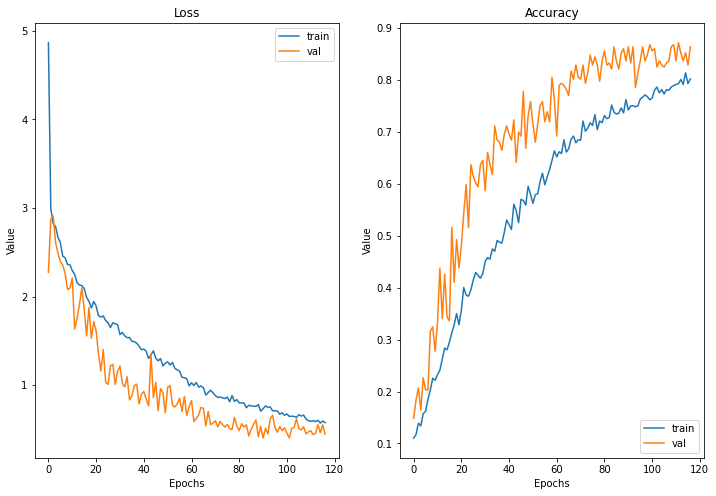

*******************number_7_kfold_model*******************
Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 5.4734 - accuracy: 0.1057
Epoch 00001: val_loss improved from inf to 3.97701, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 3s 47ms/step - loss: 5.4325 - accuracy: 0.1060 - val_loss: 3.9770 - val_accuracy: 0.1133 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 2.7934 - accuracy: 0.1426
Epoch 00002: val_loss improved from 3.97701 to 2.83491, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 40ms/step - loss: 2.7984 - accuracy: 0.1417 - val_loss: 2.8349 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 2.8178 - accuracy: 0.1494
Epoch 00003: val_loss did not improve from 2.83491
56/56 [==============================] - 2s 35ms/step - loss: 2.8182 - accuracy: 0.1484 - val_loss: 3.4928 - val_accuracy: 0.1289

56/56 [==============================] - 2s 40ms/step - loss: 1.6962 - accuracy: 0.4286 - val_loss: 1.0804 - val_accuracy: 0.6172 - lr: 8.0000e-04
Epoch 28/500
55/56 [============================>.] - ETA: 0s - loss: 1.6486 - accuracy: 0.4364
Epoch 00028: val_loss improved from 1.08035 to 1.04780, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 40ms/step - loss: 1.6493 - accuracy: 0.4353 - val_loss: 1.0478 - val_accuracy: 0.6367 - lr: 8.0000e-04
Epoch 29/500
55/56 [============================>.] - ETA: 0s - loss: 1.5861 - accuracy: 0.4563
Epoch 00029: val_loss did not improve from 1.04780
56/56 [==============================] - 2s 35ms/step - loss: 1.5848 - accuracy: 0.4576 - val_loss: 1.3892 - val_accuracy: 0.5859 - lr: 8.0000e-04
Epoch 30/500
55/56 [============================>.] - ETA: 0s - loss: 1.6075 - accuracy: 0.4330
Epoch 00030: val_loss did not improve from 1.04780
56/56 [==============================] - 2s 35ms/step - loss: 1.6098 - a

Epoch 55/500
55/56 [============================>.] - ETA: 0s - loss: 1.0602 - accuracy: 0.6426
Epoch 00055: val_loss did not improve from 0.62810
56/56 [==============================] - 2s 35ms/step - loss: 1.0585 - accuracy: 0.6445 - val_loss: 0.8141 - val_accuracy: 0.7461 - lr: 4.0960e-04
Epoch 56/500
55/56 [============================>.] - ETA: 0s - loss: 1.0639 - accuracy: 0.6460
Epoch 00056: val_loss did not improve from 0.62810
56/56 [==============================] - 2s 35ms/step - loss: 1.0646 - accuracy: 0.6451 - val_loss: 0.7073 - val_accuracy: 0.7891 - lr: 4.0960e-04
Epoch 57/500
55/56 [============================>.] - ETA: 0s - loss: 1.0410 - accuracy: 0.6392
Epoch 00057: val_loss did not improve from 0.62810
56/56 [==============================] - 2s 35ms/step - loss: 1.0443 - accuracy: 0.6378 - val_loss: 0.7161 - val_accuracy: 0.7578 - lr: 4.0960e-04
Epoch 58/500
55/56 [============================>.] - ETA: 0s - loss: 0.9954 - accuracy: 0.6608
Epoch 00058: val_loss 

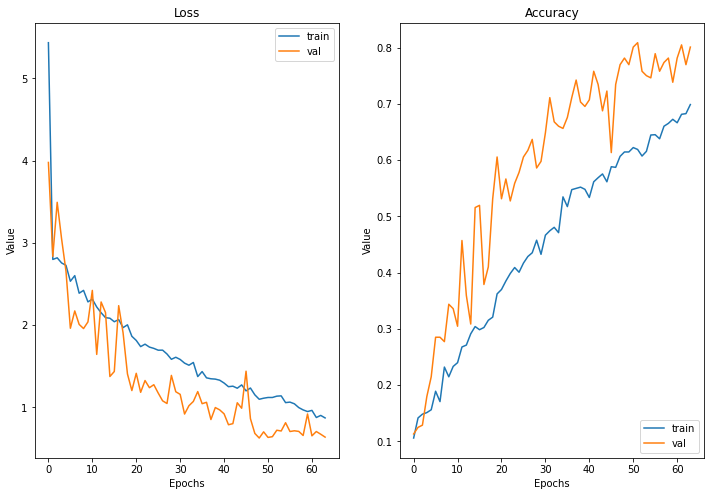

*******************number_8_kfold_model*******************
Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 4.9381 - accuracy: 0.1085
Epoch 00001: val_loss improved from inf to 2.63597, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 3s 46ms/step - loss: 4.8989 - accuracy: 0.1088 - val_loss: 2.6360 - val_accuracy: 0.1133 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 2.8683 - accuracy: 0.1290
Epoch 00002: val_loss did not improve from 2.63597
56/56 [==============================] - 2s 35ms/step - loss: 2.8676 - accuracy: 0.1283 - val_loss: 5.5993 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 2.8245 - accuracy: 0.1528
Epoch 00003: val_loss did not improve from 2.63597
56/56 [==============================] - 2s 35ms/step - loss: 2.8206 - accuracy: 0.1529 - val_loss: 2.6593 - val_accuracy: 0.1172 - lr: 0.0010
Epoch 4/500
55/56 [=============

55/56 [============================>.] - ETA: 0s - loss: 1.7221 - accuracy: 0.4256
Epoch 00027: val_loss did not improve from 1.14704
56/56 [==============================] - 2s 35ms/step - loss: 1.7247 - accuracy: 0.4258 - val_loss: 1.3759 - val_accuracy: 0.4805 - lr: 8.0000e-04
Epoch 28/500
55/56 [============================>.] - ETA: 0s - loss: 1.7481 - accuracy: 0.3977
Epoch 00028: val_loss did not improve from 1.14704
56/56 [==============================] - 2s 35ms/step - loss: 1.7498 - accuracy: 0.3956 - val_loss: 1.3378 - val_accuracy: 0.5273 - lr: 8.0000e-04
Epoch 29/500
55/56 [============================>.] - ETA: 0s - loss: 1.6496 - accuracy: 0.4244
Epoch 00029: val_loss did not improve from 1.14704
56/56 [==============================] - 2s 35ms/step - loss: 1.6511 - accuracy: 0.4230 - val_loss: 1.1984 - val_accuracy: 0.6094 - lr: 8.0000e-04
Epoch 30/500
55/56 [============================>.] - ETA: 0s - loss: 1.6814 - accuracy: 0.4170
Epoch 00030: val_loss did not impro

55/56 [============================>.] - ETA: 0s - loss: 1.0600 - accuracy: 0.6375
Epoch 00054: val_loss did not improve from 0.76394
56/56 [==============================] - 2s 35ms/step - loss: 1.0601 - accuracy: 0.6378 - val_loss: 1.1214 - val_accuracy: 0.6797 - lr: 3.2768e-04
Epoch 55/500
55/56 [============================>.] - ETA: 0s - loss: 1.0446 - accuracy: 0.6477
Epoch 00055: val_loss improved from 0.76394 to 0.76153, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 39ms/step - loss: 1.0431 - accuracy: 0.6484 - val_loss: 0.7615 - val_accuracy: 0.7695 - lr: 3.2768e-04
Epoch 56/500
55/56 [============================>.] - ETA: 0s - loss: 1.0662 - accuracy: 0.6364
Epoch 00056: val_loss did not improve from 0.76153
56/56 [==============================] - 2s 35ms/step - loss: 1.0626 - accuracy: 0.6356 - val_loss: 0.8359 - val_accuracy: 0.7500 - lr: 3.2768e-04
Epoch 57/500
55/56 [============================>.] - ETA: 0s - loss: 1.0513 - accura

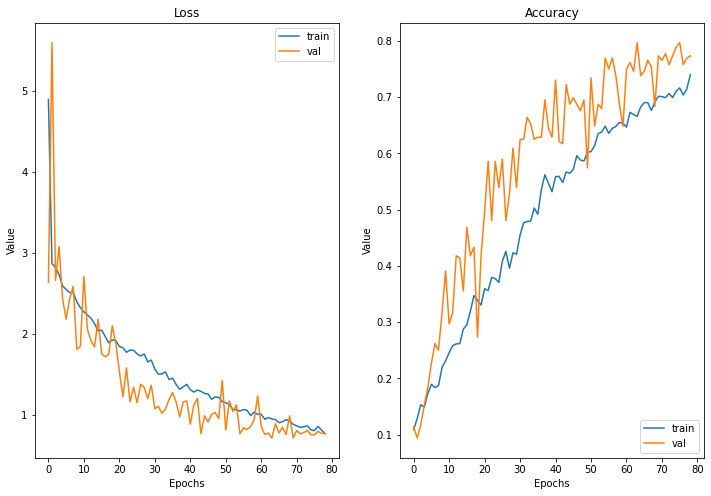

In [38]:
RX_train, RX_test = get_stacking(rexnet_model, X_trains, y_trains)

## Pickle 파일 저장

In [39]:
pickle.dump(RX_train, open("./pickle/RX_train.pkl", "wb"))
pickle.dump(RX_test, open("./pickle/RX_test.pkl", "wb"))